In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps
import tifffile as tf

In [2]:
class BasicOpticalGatingMultiplePeaks(OG.BasicOpticalGating):
    def get_phase(self, sad):
        from scipy.signal import find_peaks

        frame_minima = np.argmin(sad[self.settings["padding_frames"]:-self.settings["padding_frames"]]) + self.settings["padding_frames"]
        if frame_minima > self.settings["padding_frames"]:
            if len(self.frame_minimas) > 0 and abs(frame_minima - self.frame_minimas[-1]) % self.sequence_manager.reference_indices[1] - self.sequence_manager.reference_indices[0] > 3:
                frame_minima = self.frame_minimas[-1] + 1
                if frame_minima > len(sad) - self.settings["padding_frames"]:
                    frame_minima = self.settings["padding_frames"]
            if frame_minima > len(sad) - self.settings["padding_frames"]:
                frame_minima = 0

        y_1 = sad[frame_minima - 1]
        y_2 = sad[frame_minima]
        y_3 = sad[frame_minima + 1]
        
        subframe_minima = OG.v_fitting(y_1, y_2, y_3)[0]
        phase = 2 * np.pi * ((frame_minima - self.settings["padding_frames"] + subframe_minima) / self.sequence_manager.reference_period)

        return phase, frame_minima

In [3]:
data_src = r"D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield"
frame_rate = 80

In [4]:
oog_multiple = BasicOpticalGatingMultiplePeaks()
oog_multiple.sequence_manager.set_source(data_src)
oog_multiple.sequence_manager.skip_frames = 300
oog_multiple.run()

oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(data_src)
oog.sequence_manager.skip_frames = 300
oog.run()

Setting source to D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield
Getting reference sequence


PermissionError: [Errno 13] Permission denied: 'D:\\Data\\2012-06-20 13.34.11 vid 2x2 multi phase single plane\\brightfield'

In [ ]:
print(np.diff(oog.frame_minimas))

[  0   1   2   1   1   0   1   2   0   1   1   1   1   1 -32   0   0   0
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   0 -34   1   1   1   1   1   1   2   0   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   0   2   1   1   1   1   1   1   1   1   1
 -35   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   0   2   1   1   0   2   1   1   1   1   1   1   1   1   1
   1 -35   1   1   1   1   1   1   1   1   2   0   1   1   1   1   1   0
   2   1   1   2   1   1   0   0   2   1   1   1   1   1   1   1   1   1
   1 -35   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   2   0   1   1   0   2   1   1   1   1   0   1   1   1   1
 -35   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   2
   1   1   1   1   1   1   1   1   0   2   1   1   1   1   0   1   1   1
 -34   1   1   1   1   1   1   1   1   1   1   1   

In [ ]:
print(np.where(oog.delta_phases>0.5))

(array([14], dtype=int64),)


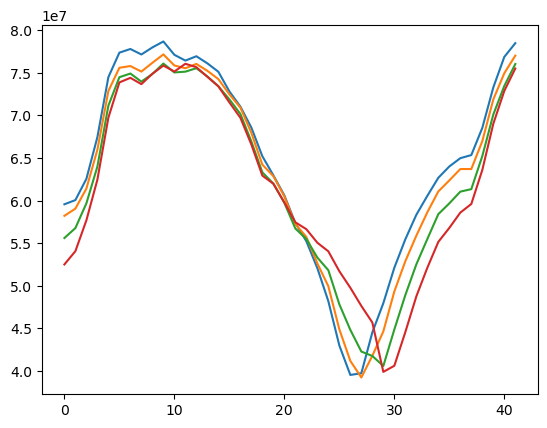

In [ ]:
for i in range(6,10):
    plt.plot(oog.sads[i])
plt.show()

In [ ]:
print(np.where(oog.delta_phases > 0.5))

(array([14], dtype=int64),)


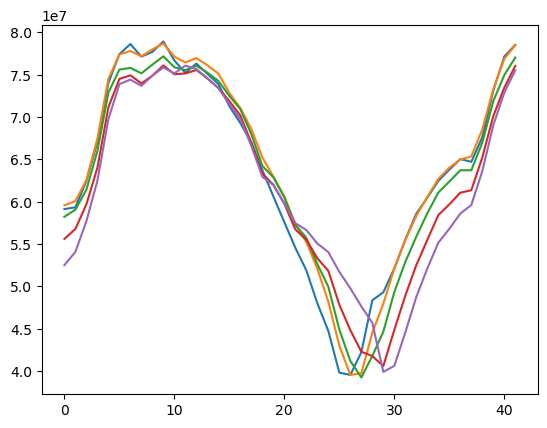

In [ ]:
plt.plot(oog.sads[5])
plt.plot(oog.sads[6])
plt.plot(oog.sads[7])
plt.plot(oog.sads[8])
plt.plot(oog.sads[9])

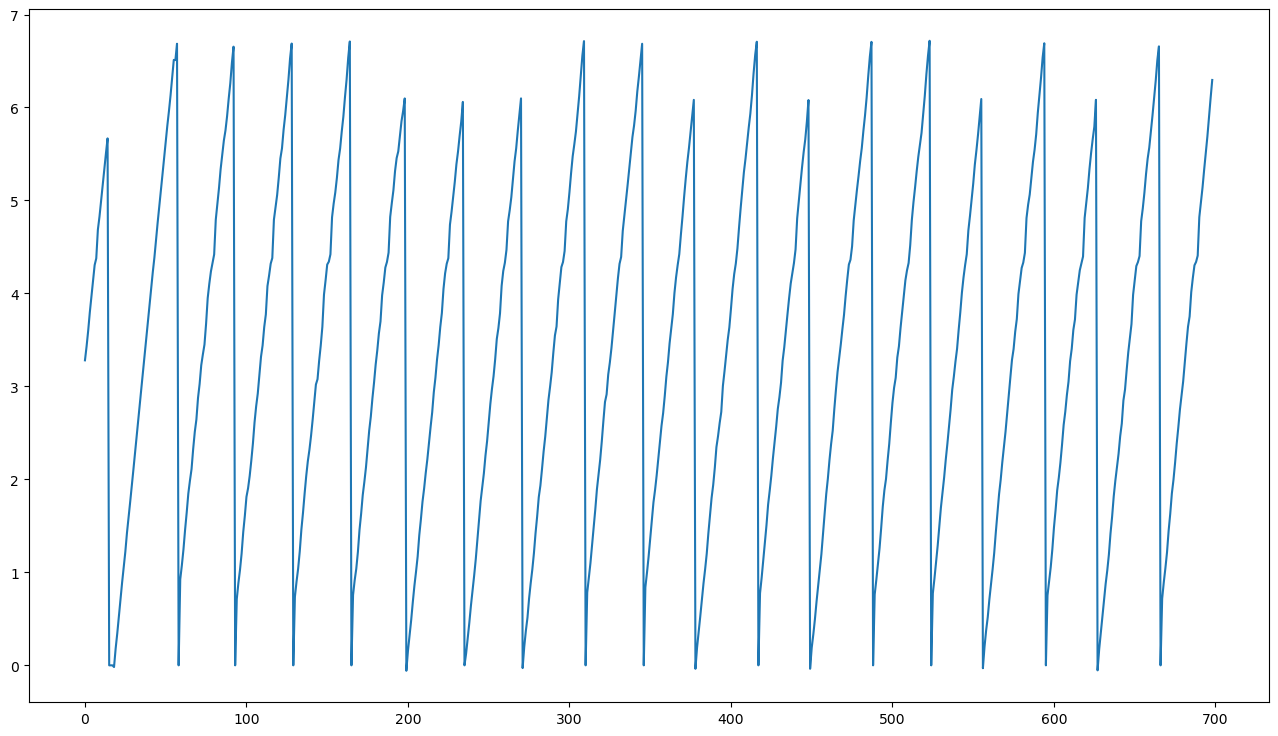

'plt.figure(figsize = (16,9))\nplt.scatter(oog.phases[1::], oog.delta_phases)\nplt.scatter(oog_multiple.phases[1::], oog_multiple.delta_phases)\nplt.show()'

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(oog_multiple.phases)
#plt.plot(oog.phases)
plt.show()

"""plt.figure(figsize = (16,9))
plt.scatter(oog.phases[1::], oog.delta_phases)
plt.scatter(oog_multiple.phases[1::], oog_multiple.delta_phases)
plt.show()"""

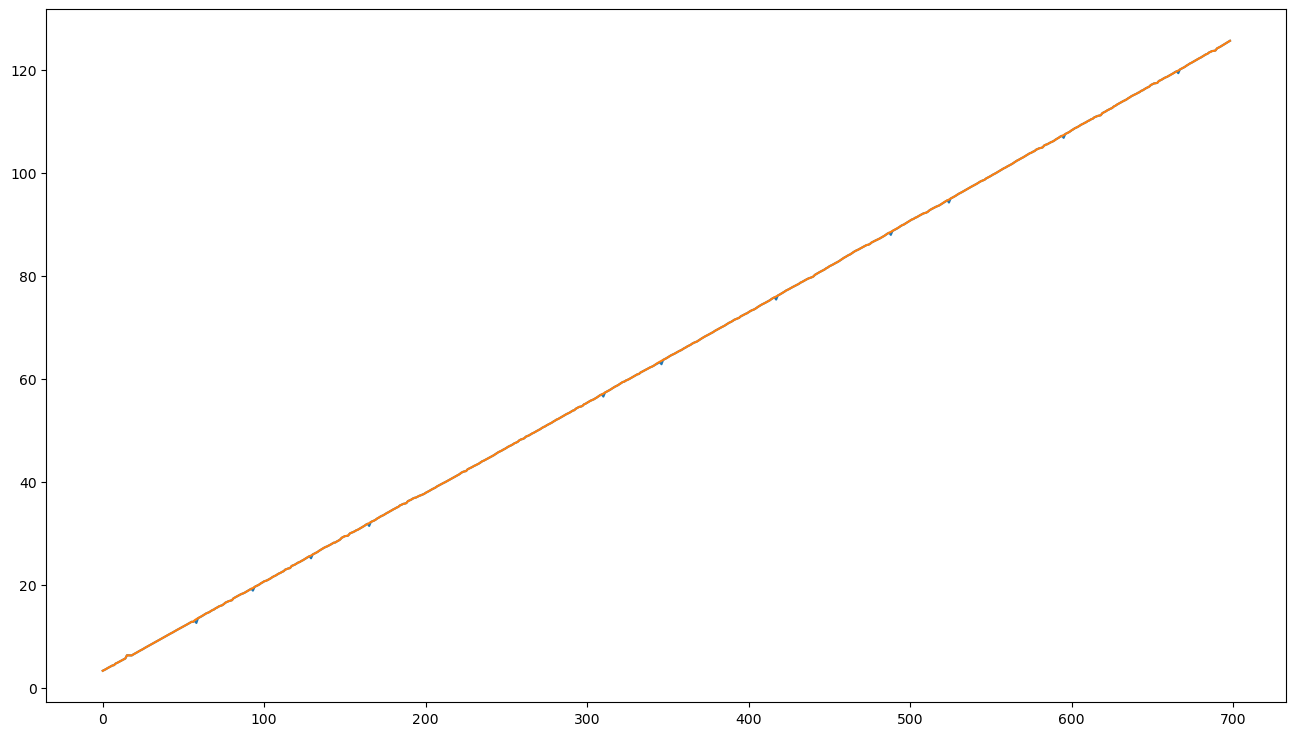

In [ ]:
plt.figure(figsize = (16,9))
plt.plot(oog_multiple.unwrapped_phases)
plt.plot(oog.unwrapped_phases)

In [5]:
def get_diagonal_ordered(source_folder, data_src, frame_rate, ordered = True):
    # Run OOG
    data_src = source_folder + data_src
    #oog = BasicOpticalGatingMultiplePeaks()
    oog = OG.BasicOpticalGating()
    oog.sequence_manager.set_source(data_src)
    oog.sequence_manager.skip_frames = 300
    #oog.sequence_manager.max_frames = 400
    oog.run()

    plt.plot(oog.phases)

    # Sort phases
    if ordered == True:
        order = np.argsort(oog.phases)
    else:
        order = np.arange(len(oog.phases))

    # Get video for comparisons
    video_array = OG.SequenceManager.load_tif(data_src)[order]

    # Apply drift correction
    """drifts = np.array(oog.drifts)[order]
    crop_x = np.max(np.abs(drifts))
    crop_y = np.max(np.abs(drifts))
    video_array_cropped = np.empty((video_array.shape[0], video_array.shape[1] - 2 * crop_x, video_array.shape[2] - 2 * crop_y), dtype = np.uint16)
    for i, drift in enumerate(drifts):
        dx, dy = drift
        rectF = [crop_x - dx, video_array[0].shape[0] - crop_x - dx, crop_y - dy, video_array[0].shape[1] - crop_y - dy]  # X1,X2,Y1,Y2
        video_array_cropped[i] = video_array[i][rectF[0] : rectF[1], rectF[2] : rectF[3]]"""
    
    video_array_cropped  = video_array

    tf.imwrite(source_folder + "drift_corrected.tif", video_array_cropped)

    # Get diffs array
    diffs_array = []
    va = video_array_cropped.astype(np.uint16)
    for i in range(va.shape[0]):
        diffs_array.append(jps.sad_with_references(va[i], va))
    diffs_array = np.array(diffs_array)
    diffs_array = np.delete(diffs_array,range(0,diffs_array.shape[0]**2,(diffs_array.shape[0]+1))).reshape(diffs_array.shape[0],(diffs_array.shape[1]-1))

    # And plot
    plt.figure(figsize = (20,20))
    plt.imshow(diffs_array, interpolation="none")
    plt.axvline(oog.sequence_manager.reference_indices[0], c = "crimson", lw = 1)
    plt.axvline(oog.sequence_manager.reference_indices[1], c = "crimson", lw = 1)
    plt.colorbar()
    plt.show()

    tf.imwrite(source_folder + "\sorted.tif", video_array_cropped)

    return video_array_cropped

In [6]:
get_diagonal_ordered(r"D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane", r"\brightfield\*tif", 80, True)

Setting source to D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield\*tif
Getting reference sequence
